In [692]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as sci
import scipy.misc as sci
from IPython.display import clear_output as clr
%matplotlib inline

In [1059]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne

In [1063]:
from sklearn.cluster import KMeans as kmodel

In [2]:
import matplotlib as mpl
mpl.rc('image', cmap='gray')

In [676]:
def read_images(filenames_list):
    imgs = []
    for name in filenames_list:
        img = sci.imread(name)
        imgs.append(img)
    return imgs

In [677]:
def gaussian(x, mu, lamda):
    return np.exp(np.dot((x-mu).T,np.dot(lamda, x-mu)))*np.sqrt(np.linalg.det(lamda/(2*np.pi)))

In [678]:
def normalize_01(y):
    return (y - y.min())/(y.max() - y.min())

In [679]:
def gaussian_calc(X, lam_1):
    
    N , D = X.shape
    mu = 0
    eye = np.eye(D)
    g_2 = np.diag(gaussian(X.T, mu, lam_1*eye))
    return g_2.T

In [680]:
def convolve(imgn, kernel):
    
    size = kernel.shape[0]
    dims = imgn.shape[0] - size
    vals_1 = np.zeros((dims,dims))
    for i in range(dims):
        for j in range(dims):
            vals_1[i,j] = np.sum(kernel*imgn[i:i+size, j:j+size])
            
    return vals_1

In [681]:
def conv_laplacian(img_s, X,  size, octaves = [.1,.5,1,5], norm = True):
    
    width ,height = img_s.shape
    
    images2return = []
    for z in range(len(octaves)-1):
        
        lap_eg_1 = gaussian_calc(X, octaves[z]).reshape(2*size+1,2*size+1)
        lap_eg_2 = gaussian_calc(X, octaves[z+1]).reshape(2*size+1,2*size+1)
        
        
        vals_1 = convolve(img_s, lap_eg_1)
        vals_2 = convolve(img_s, lap_eg_2)

        lap_img_1= normalize_01(vals_1)*255
        lap_img_2= normalize_01(vals_2)*255
        lap_img = (lap_img_1 - lap_img_2)
    
        if(norm):
            img = normalize_01(lap_img)*255
            
        images2return.append(img)
        
    return images2return

In [682]:
def find_local_maximas(imgs, n_points):
    
    c, n, m = imgs.shape
    l_opt = np.zeros((c,n,m))
    for k in range(1,c-1):
        for i in range(1,n-1):
            for j in range(1,m-1):
                cond_1 = imgs[k,i,j]>imgs[k,i,j+1] and imgs[k,i,j]>imgs[k,i,j-1]
                cond_2 = imgs[k,i,j]>imgs[k,i+1,j] and imgs[k,i,j]>imgs[k,i-1,j]
                cond_3 = imgs[k,i,j]>imgs[k+1,i,j] and imgs[k,i,j]>imgs[k-1,i,j]
                l_opt[k,i,j] = imgs[k,i,j]*1*(cond_1 and cond_2 and cond_3)
            
            
            
    
    cuml = np.sum(l_opt, axis =0).reshape(-1,1)
    idx = np.argsort(cuml, axis = 0)[-n_points:]
    cuml[idx] = 1001
    return ((cuml>1000)*255).reshape(n,m)

In [683]:
def get_gradients(img):
    
    n,m = img.shape
    
    v_grad = img[1:,:] - img[:-1,:]
    h_grad = img[:,1:] - img[:,:-1]
    
    return v_grad[1:,1:-1], h_grad[1:-1,1:]

In [684]:
def compute_fvector(loc_max, v_grad, h_grad, w_size):
    
    assert(v_grad.shape == h_grad.shape)
    
    m, n = loc_max.shape
    a, b = v_grad.shape
    
    
    diff = (a-m)//2
    
    v_grad_c = v_grad[diff:-diff+1, diff:-diff+1]
    h_grad_c = h_grad[diff:-diff+1, diff:-diff+1]
    
    
    theta = np.arctan2(v_grad_c,(h_grad_c + 10e-32))
    
    dims = int(m//w_size)
    
    features = []
    for i in range(dims):
        for j in range(dims):
            wind = loc_max[i*w_size:(i+1)*w_size,j*w_size:(j+1)*w_size]
            if(np.sum(wind > 200)):
                feat_1 = v_grad_c[i*w_size:(i+1)*w_size,j*w_size:(j+1)*w_size].reshape(-1,1)
                feat_2 = h_grad_c[i*w_size:(i+1)*w_size,j*w_size:(j+1)*w_size].reshape(-1,1)
                feat_3 = theta[i*w_size:(i+1)*w_size,j*w_size:(j+1)*w_size].reshape(-1,1)
                
                feat = np.vstack([feat_1,feat_2,feat_3])
                features.append(feat.reshape(-1))
                
    return features

In [693]:
def compute_feats(img_rsp,size,w_size,p_max):
#     size = 3
    rng = np.arange(-size,size+1)
    mat = np.meshgrid(rng,rng)
    X = np.hstack([mat[0].reshape(-1,1), mat[1].reshape(-1,1)])
    img_convd = conv_laplacian(img_rsp, X, size, octaves = [0.00001,0.0001,0.001,0.01,0.1,1,10])
    img_loc_max = find_local_maximas(np.stack(img_convd),p_max)
    v_grad, h_grad = get_gradients(img_rsp)
    feats = compute_fvector(img_loc_max, v_grad, h_grad, w_size)
    
    return feats

In [877]:
def compute_feats_all(imgs, size = 3, w_size = 10, p_max =200, r_size = 128):
    
    L = len(imgs)
    count = 0
    features = []
    labels = []
    for img in imgs:
        img_rshp = np.mean(sci.imresize(img, [r_size, r_size]), axis = 2)
        feats = compute_feats(img_rshp,size,w_size,p_max)
        
        ll = [count for i in range(len(feats))]
        
        if(len(features) == 0):
            features = feats
            labels = ll
        else:
            features.extend(feats)
            labels.extend(ll)
        
        clr(wait = True)
        print(count+1, "out of ", L, "are done.")
        count+=1
    return features, labels

In [2071]:
img_list = ['01.jpg','02.jpg','me.png']

In [2072]:
imgs = read_images(img_list)

/home/abhikcr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


In [2073]:
f_vecs, l_vecs = compute_feats_all(imgs, p_max = 500)

3 out of  3 are done.


In [2074]:
len(f_vecs),len(l_vecs)

(309, 309)

In [2234]:
n_cluster = 30
c_model = kmodel(n_cluster)

In [2235]:
p_vecs = c_model.fit_predict(f_vecs)

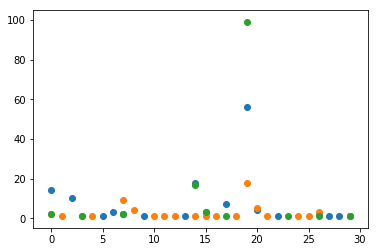

In [2236]:
c_vecs =[]
for i in range(5):
    a,b = np.unique(p_vecs[np.array(l_vecs) == i], return_counts = True)
    plt.scatter(a,b)
    vec = np.zeros((n_cluster))
    for i in range(a.shape[0]):
        vec[a[i]] = b[i]
    c_vecs.append(vec)
plt.show()

In [2237]:
vec_norms = []
for i in range(len(c_vecs)):
    vec = c_vecs[i]
    vec_norm = (vec-vec.min())/(vec.max() - vec.min())
    vec_norms.append(vec_norm)

/home/abhikcr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [2238]:
vec_norms[4].shape

(30,)

In [2272]:
img_test = imgs[2][50:-30, 50:-50]

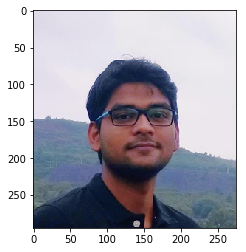

In [2273]:
plt.imshow(img_test)
plt.show()

In [2274]:
f_vecs_t, _ = compute_feats_all([img_test], p_max = 350)

1 out of  1 are done.


In [2275]:
len(f_vecs_t)

90

In [2276]:
p_vec_test = c_model.predict(f_vecs_t)

In [2277]:
p_vec_test

array([19, 14, 14, 19, 19, 19, 19, 14, 14, 19, 19, 19, 19, 19, 19,  0, 19,
       19, 19, 19, 14, 19, 19, 19, 19,  0, 19, 19, 14, 19,  7, 19, 14, 19,
       19, 26, 19,  7, 19, 19, 19, 19, 14, 19, 14, 19, 19, 19, 19, 19, 19,
       14, 19, 19, 19, 19, 14, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 14, 19, 19,  0, 19, 19, 19, 19, 19, 19, 19, 19, 14, 19,
        0, 14, 19, 19, 19], dtype=int32)

In [2278]:
a,b = np.unique(p_vec_test, return_counts = True)
vec = np.zeros((n_cluster))
for i in range(a.shape[0]):
        vec[a[i]] = b[i]
vec_norm = (vec-vec.min())/(vec.max() - vec.min())

In [2279]:
vec_norm.shape

(30,)

In [2280]:
olddist = 10e32
pred = -10
for i in range(len(vec_norms)):
    vec = vec_norms[i]
    dist = np.sum((vec - vec_norm)**2)
    if(dist < olddist):
        pred = i
        olddist = dist

/home/abhikcr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


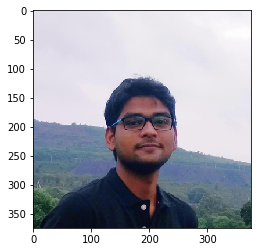

In [2281]:
plt.imshow(read_images([img_list[pred]])[0])
plt.show()

In [2282]:
olddist

0.0038216076481528754